In [1]:
import torch
import datetime
import math
import matplotlib.pyplot as plt
from torch import optim
from torch import Tensor
from torch.autograd import Variable
from torch import nn
from torch.nn import functional as F
import dlc_practical_prologue 
import warnings
warnings.filterwarnings('ignore')     
#Size of the data to load
size=1000;
train_input, train_target, train_classes, test_input, test_target, test_classes = \
    dlc_practical_prologue.generate_pair_sets(size)
train_input, train_target, train_classes = Variable(train_input), Variable(train_target), Variable((train_classes))
test_input, test_target, test_classes = Variable(test_input), Variable(test_target), Variable(test_classes)

ModuleNotFoundError: No module named 'dlc_practical_prologue'

In [58]:
#getting 10 different test sets to verify each model against all of them
#the test error will be the average of the 10 test errors I get
test_input_10 = torch.Tensor(10, 2*1000, 14*14)
test_target_10 = torch.Tensor(10, 1000)
test_classes_10 = torch.Tensor(10, 2*1000)
for i in range(1,10):
    train_input, train_target, train_classes, test_input, test_target, test_classes = \
    dlc_practical_prologue.generate_pair_sets(size)
    test_input, test_target, test_classes = Variable(test_input), Variable(test_target), Variable(test_classes)
    test_input_10[i,:,:] = test_input.reshape([2000,196])
    test_target_10[i,:] = test_target
    test_classes_10[i,:] = test_classes.reshape([2000])
my_train_input = train_input.reshape([2000,196])
my_train_classes = train_classes.reshape([2000])

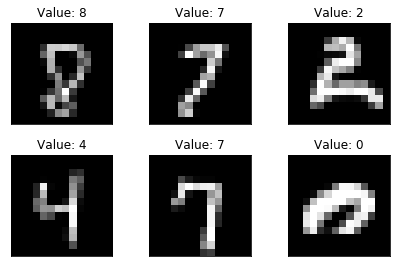

In [11]:
# displaying samples of data

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(test_input[i][0], cmap='gray', interpolation='none')
  plt.title("Value: {}".format(test_classes[i][0]))  
  plt.tight_layout()
  plt.xticks([])
  plt.yticks([])

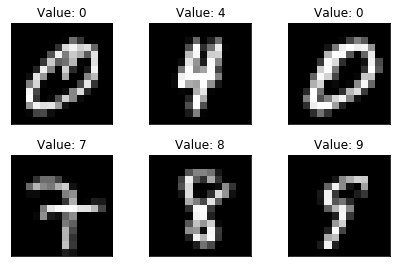

In [12]:
# displaying samples of data
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(test_input[i][1], cmap='gray', interpolation='none')
  plt.title("Value: {}".format(test_classes[i][1]))  
  plt.tight_layout()
  plt.xticks([])
  plt.yticks([])

# First neural net
Train the model on all the 2000 images in train_input

In [13]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# number of epoch
num_epochs = 25
# batch size to compute mini-batch
batch_size = 100
# number of pixels in the image 
input_size = 196
# number of possible digit: 0 to 9 
num_class = 10
# small step to find a minima
learning_rate = 0.004
# hidden size
hidden_size = 500
# p dropout
p_dropout = 0

# Fully connected neural network
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_class, dropout_p):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU() 
        self.softmax = nn.Softmax()
        self.layer2 = nn.Linear(hidden_size, hidden_size)  
        self.layer3 = nn.Linear(hidden_size, num_class) 
        self.dropout = nn.Dropout(dropout_p) 
    
    def forward(self, x):
        outputs = self.layer1(x)
        outputs = self.relu(outputs)
        outputs = self.layer2(outputs)
        outputs = self.dropout(outputs)
        outputs = self.relu(outputs)
        outputs = self.layer3(outputs)
        return outputs

In [14]:
# function to train each model
def train_model(model_, my_train_input_, my_train_classes_, criterion_, optimizer_,num_epochs_,batch_size_,learning_rate_decay):
    # getting start time of train to get the train time at the end thanks to "end_time"
    start_time = datetime.datetime.now()
    # list to get train and test errors at each epoch
    train_error = []
    test_error = []
    # train function
    # Learning rate decay can be enabled or disabled than to an input in the function's parameters
    if learning_rate_decay:
        lambda_ = lambda epoch: 0.8 ** epoch
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer_, lr_lambda=lambda_)
    for epoch in range(1, num_epochs_+1):
        # using technique of mini batch (size of the batch in the function's parameters)
        for i in range(int(len(my_train_input_)/batch_size_)):  
            # getting images and labels in right format
            images = my_train_input_.narrow(0,i*batch_size_,batch_size_).to(device)
            labels = my_train_classes_.narrow(0,i*batch_size_,batch_size_).to(device)

            # Forward pass
            outputs = model_(images)
            loss = criterion_(outputs, labels)

            # Backward and optimize
            optimizer_.zero_grad()
            loss.backward()
            optimizer_.step()

        if learning_rate_decay:
            scheduler.step()
        # getting train error at each epoch
        train_error.append(test_accuracy(model_, my_train_input_, my_train_classes_))
        test_ = []
        # getting test errors on 10 different samples
        for i in range(1,10):
            test_.append(test_accuracy(model_, test_input_10[i,:,:], test_classes_10[i,:]))
        # getting the test error as the mean of the 10 we got
        test_error.append(sum(test_) / len(test_))
    # getting end time and training time
    end_time = datetime.datetime.now()
    training_time = end_time - start_time
    print ('Loss: {:.4f} on epoch: {}, train error: {:.5f}, avg test error on 10 different samples: {:.5f}'.format(loss.item(),epoch,train_error[-1],test_error[-1]))
    return train_error, test_error, training_time

In [15]:
def test_accuracy(model_, my_test_input_, my_test_classes_):
    total = my_test_input_.size(0)
    outputs = model_(my_test_input_)
    _, predictions = torch.max(outputs.data, 1)
    well_predicted_count = (predictions.long() == my_test_classes_.long()).sum().item()

    return 1 - well_predicted_count / total